# Pathway Analysis

The primary goal of Pathway Analysis (PA) is to assess data collected from high-throughput technologies, discovering meaningful group of genes that are altered in case samples when compared to a control. In this approach, PA methods attempt to overcome the challenge of comprehending a huge lists of important, but isolated genes detached from biological context, which are the principal output of differential expression analysis. Pathway enrichment analysis is a common strategy to tackling this problem that summarizes the large gene list as a smaller list of more clearly interpretable pathways. Pathways are statistically tested for over-representation in the experimental gene list relative to what would be expected by chance, using several common statistical tests that take into account the number of genes detected in the experiment, their relative ranking, and the number of genes annotated to a pathway of interest.

A good technique to analyze gene sets is to compare them to well-annotated gene sets (biological pathways). For example, Over-representation Analysis (ORA) counts the number of similar genes shared by an input gene set and each annotated gene set and applies a statistical test to evaluate the overlap's statistical significance. A p-value cutoff, e.g. 0.05, is used to identify annotated gene sets with significant overlaps to the input gene set. Gene Set Enrichment Analysis (GSEA) seeks to avoid the necessity for an ad hoc cutoff (e.g. expression fold change) in identifying the input gene set. GSEA ranks all genes in the genome by differential expression level and checks if any annotated gene set is scored unexpectedly high or low.

## Learning Objectives:
1. Introduction to enrichment analysis
3. Enrichment analysis using different methods.
4. Saving results.

## Enrichment analysis
 Gene Set Enrichment Analysis methods help gain insight into obtained gene lists by identifying pathways that are enriched in a gene list more than would be expected by chance. The three major steps involved the process include; definition of a gene list from omics data, determination of statistically enriched pathways, and visualization and interpretation of the results.

### Loading and mapping DE genes

In [59]:
data <- readRDS("./data/DE_genes.rds")
rownames(data) <- data$PROBEID
head(data)
dim(data)

,PROBEID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
222178_s_at,222178_s_at,-0.4473780,0.3653633,-73.01106,4.019112e-55,2.197450e-50,81.05538
224687_at,224687_at,-4.1431631,2.2572347,-48.92036,5.489424e-46,1.500671e-41,74.18354
207488_at,207488_at,-0.4017530,0.6243144,-39.29933,4.735684e-41,8.630785e-37,68.83493
239226_at,239226_at,0.4483302,1.3245501,28.36499,7.626558e-34,1.042455e-29,58.84908
234109_x_at,234109_x_at,-0.2289726,0.7508256,-27.67010,2.635337e-33,2.881741e-29,58.00438
212833_at,212833_at,-2.5976592,1.7308944,-24.01172,2.914912e-30,2.656213e-26,52.99567


[1] 54675     7

In [60]:
suppressMessages({
  library(hgu133plus2.db)
  library(AnnotationDbi)
})

In [61]:
probeIDs = data$PROBEID

In [62]:
suppressMessages({
annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID','GENENAME','SYMBOL'))
})

In [63]:
head(annotLookup)

,PROBEID,GENENAME,SYMBOL
,<chr>,<chr>,<chr>
1,222178_s_at,NA,NA
2,224687_at,ankyrin repeat and IBR domain containing 1,ANKIB1
3,207488_at,NA,NA
4,239226_at,NA,NA
5,234109_x_at,one cut homeobox 3,ONECUT3
6,212833_at,solute carrier family 25 member 46,SLC25A46


In [64]:
# Merge DE result  data frame with annotation table
data = merge(annotLookup, data, by="PROBEID")

In [65]:
head(data)

,PROBEID,GENENAME,SYMBOL,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1007_s_at,discoidin domain receptor tyrosine kinase 1,DDR1,-0.23858465,1.0967772,-2.08257585,0.04210211,0.2531265,-4.284228
2,1053_at,replication factor C subunit 2,RFC2,0.05830367,0.9657758,1.42311356,0.16052793,0.4674726,-5.359907
3,117_at,heat shock protein family A (Hsp70) member 6,HSPA6,-0.01138494,1.1501582,-0.08100885,0.93573821,0.9861536,-6.337785
4,121_at,paired box 8,PAX8,0.02301084,1.0581847,0.87166663,0.38729816,0.7236528,-5.968512
5,1255_g_at,guanylate cyclase activator 1A,GUCA1A,0.36999950,1.4080351,1.78615022,0.07976123,0.3351480,-4.812134
6,1294_at,ubiquitin like modifier activating enzyme 7,UBA7,-0.11221434,1.0859983,-1.61593670,0.11200995,0.3925252,-5.082923


### Enrichment analysis using ORA
Over-representation (or enrichment) analysis is a statistical method that determines whether genes from pre-defined sets (ex: those belonging to a specific GO term or KEGG pathway) are present more than would be expected (over-represented) in a subset of your data. The p-value can be calculated by hyper-geometric distribution.

where N is the total number of genes in the background distribution, M is the number of genes within that distribution that are annotated (either directly or indirectly) to the gene set of interest, n is the size of the list of genes of interest and k is the number of genes within that list which are annotated to the gene set. The background distribution by default is all the genes that have annotation.

### Over Representation Analysis Using GO and KEGG
Getting the DE genes from  `limma` result

In [66]:
# Getting a list of DE genes
DEGenes <- data[!is.na(data$adj.P.Val) & data$adj.P.Val <= 0.05,]
# Select gene symbol
DEGenes <- DEGenes$SYMBOL
# Remove gene with NA symbol
DEGenes <- na.omit(DEGenes)
# Remove duplicated genes
DEGenes <- unique(DEGenes)
length(DEGenes)

[1] 546

In [67]:
#Defining background set
backgroundSet <- data$SYMBOL
backgroundSet <- na.omit(backgroundSet)
backgroundSet <- unique(backgroundSet)
length(backgroundSet)

[1] 22242

In [128]:
suppressMessages({
  library(tidyverse)
})

In [129]:
gmt2geneset <- function(path){
  genesets <- read_tsv(path, col_names = F) %>% apply(MARGIN = 1, function(r){
    genes = unique(r[-(1:2)])
    list(
      id = r[1],
      description = r[2],
      genes = genes[!is.na(genes)]
    )
  })

  gs <- lapply(genesets, function(g) g$genes %>% as.character())
  names(gs) <- lapply(genesets, function(g) g$id)
  gs
}

In [130]:
suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})

Warning message:
"One or more parsing issues, see `problems()` for details"


Perform over-representation analysis

In [132]:
res <- sapply(geneset, function(gs){
  # hypergeomestric test
  wBallDraw <- intersect(gs, DEGenes) %>%  length() - 1
  if (wBallDraw < 0) return(1)
  wBall <- length(DEGenes)
  bBall <- nrow(data) - length(DEGenes)
  ballDraw <- length(intersect(gs, backgroundSet))
  1 - phyper(wBallDraw, wBall, bBall, ballDraw)
})

In [136]:
res.df <- data.frame(
  pathway = names(res),
  pvalue = res
)

In [140]:
res.df$pvalue.adj <- p.adjust(res.df$pvalue, method = "fdr")
res.df <- res.df[order(!res.df$pvalue.adj),]
head(res.df)

,pathway,pvalue,pvalue.adj
,<chr>,<dbl>,<dbl>
GO:0007015,GO:0007015,1.110223e-16,1.540542e-16
GO:0007409,GO:0007409,1.110223e-16,1.540542e-16
GO:0009150,GO:0009150,1.110223e-16,1.540542e-16
GO:0009259,GO:0009259,1.110223e-16,1.540542e-16
GO:0019693,GO:0019693,1.110223e-16,1.540542e-16
GO:0031098,GO:0031098,1.110223e-16,1.540542e-16


In [158]:
suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})

Warning message:
"One or more parsing issues, see `problems()` for details"


In [159]:
res <- sapply(geneset, function(gs){
  # hypergeomestric test
  wBallDraw <- intersect(gs, DEGenes) %>%  length() - 1
  if (wBallDraw < 0) return(1)
  wBall <- length(DEGenes)
  bBall <- nrow(data) - length(DEGenes)
  ballDraw <- length(intersect(gs, backgroundSet))
  1 - phyper(wBallDraw, wBall, bBall, ballDraw)
})

res.df <- data.frame(
  pathway = names(res),
  pvalue = res
)

res.df$pvalue.adj <- p.adjust(res.df$pvalue, method = "fdr")
res.df <- res.df[order(!res.df$pvalue.adj),]
head(res.df)

,pathway,pvalue,pvalue.adj
,<chr>,<dbl>,<dbl>
hsa00010,hsa00010,0.003514458,0.03722398
hsa00020,hsa00020,0.033191479,0.15959191
hsa00030,hsa00030,0.033191479,0.15959191
hsa00040,hsa00040,0.257329575,0.61864850
hsa00051,hsa00051,0.003817844,0.03722398
hsa00052,hsa00052,0.257329575,0.61864850


## Enrichment Analysis using FGSEA


This submodule describes FGSEA, one of the tools for evaluating pathway enrichment in transcriptional data and it stands for Fast preranked Gene Set Enrichment Analysis (GSEA). It can quickly and accurately calculate arbitrarily low GSEA P-values for a collection of gene sets based on an adaptive multi-level split Monte-Carlo scheme.

 Typical experimental design consists in comparing two conditions with several replicates using a differential gene expression test followed by preranked GSEA performed against a collection of hundreds and thousands of pathways. However, the reference implementation of this method cannot accurately estimate small P-values, which significantly limits its sensitivity due to multiple hypotheses correction procedure. FGSEA, on the other hand, is able to estimate arbitrarily low GSEA P-values with a high accuracy in a matter of minutes or even seconds.


In [ ]:
# Install the fgsea package
suppressMessages({if (!require("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
  suppressWarnings(BiocManager::install("fgsea", update = F))
})

In [ ]:
# Loading the package
suppressPackageStartupMessages({
  library("fgsea")
})

In [ ]:
# Get the gene list and their statistic from DE results
#genes <- data.frame(SYMBOL = data$SYMBOL, stat= data$adj.P.Val)

stats = data$adj.P.Val
names(stats) = data$SYMBOL
head(stats)

### FGSEA Using GO

The package `fgsea` has its own function named `gmtPathways` to load the genesets from the `gmt` file. It is recommended to use this function for compatibility.

In [37]:
# Load the pathways into a named list
GO_term_hallmark <- gmtPathways("./data/GO_terms.gmt")

# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(GO_term_hallmark,head)
tmp[1:5]

$`GO:0000003`
[1] "ADAM28"  "ALDOA"   "ALKBH1"  "ARID5B"  "ATP2B2"  "B4GALT1"

$`GO:0000122`
[1] "ARID5B"  "ATF7IP"  "BARX2"   "BHLHE41" "CCNE1"   "CTBP1"  

$`GO:0000165`
[1] "ADRB3"  "ANGPT1" "BRF1"   "CAMKK2" "CCL22"  "CLEC7A"

$`GO:0000226`
[1] "ANKFN1"  "ARHGEF7" "ATF5"    "BMERB1"  "CCDC40"  "CCNB1"  

$`GO:0000278`
[1] "ANKFN1" "ATAD5"  "BABAM2" "BRF1"   "CCNB1"  "CCNE1"

In [39]:
# Running fgsea
fgseaRes <- fgsea(pathways = GO_term_hallmark,
                  stats    = stats,
                  minSize  = 15,
                  maxSize  = 500)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (62.67% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos"."
Warning message in fgseaMultilevel(...):
"There were 2 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)"


In [45]:
head(fgseaRes[order(pval), ][,-8])

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GO:0065007,2.546484e-11,1.589006e-08,0.8634154,0.3431229,1.538333,459
GO:0050789,7.479736e-10,2.333678e-07,0.8012156,0.3388931,1.514710,432
GO:0050794,1.598783e-09,3.325469e-07,0.7881868,0.3366914,1.502073,414
GO:0032501,4.659098e-09,7.177948e-07,0.7614608,0.3641697,1.592389,269
GO:0050896,5.751561e-09,7.177948e-07,0.7614608,0.3535281,1.556321,313
GO:0032502,1.143077e-08,1.188800e-06,0.7477397,0.3665868,1.599132,253


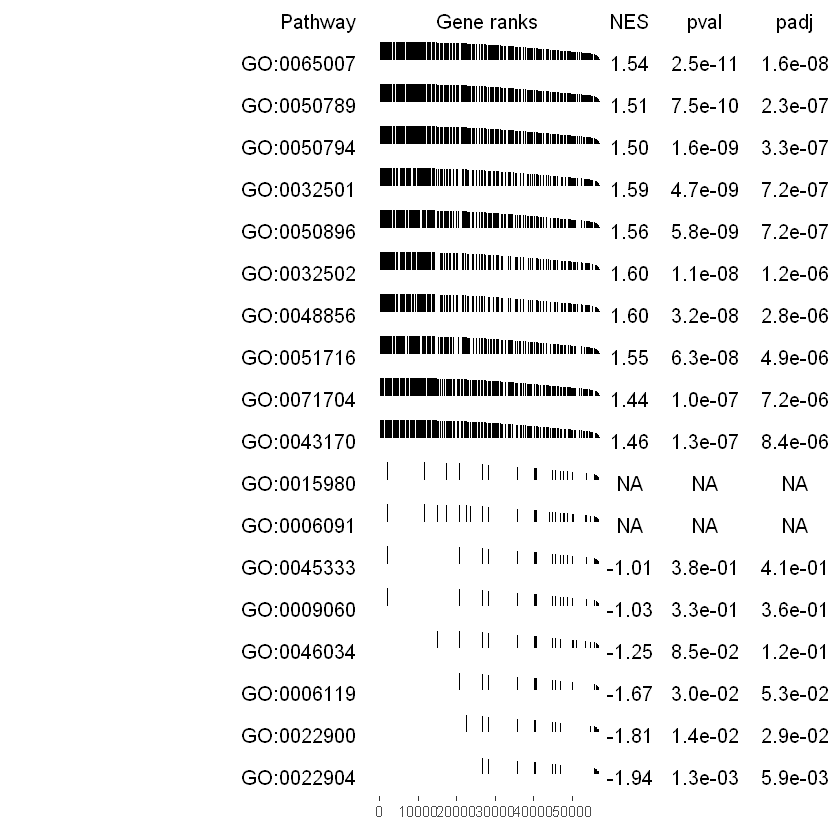

In [49]:
topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n=10), pathway]
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n=10), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(GO_term_hallmark[topPathways], stats, fgseaRes,
              gseaParam=0.5)

### FGSEA Using KEGG

In [50]:
# Load the pathways into a named list
KEGG_hallmark <- gmtPathways("./data/KEGG_pathways.gmt")

# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(KEGG_hallmark,head)
tmp[1:5]

$hsa00010
[1] "HK3"   "HK1"   "HK2"   "HKDC1" "GCK"   "GPI"  

$hsa00020
[1] "CS"   "ACLY" "ACO2" "ACO1" "IDH1" "IDH2"

$hsa00030
[1] "GPI"  "G6PD" "PGLS" "H6PD" "PGD"  "RPE" 

$hsa00040
[1] "GUSB"    "KL"      "UGT2A1"  "UGT2A3"  "UGT2B17" "UGT2B11"

$hsa00051
[1] "MPI"   "PMM2"  "PMM1"  "GMPPB" "GMPPA" "GMDS"

In [51]:
# Running fgsea
fgseaRes <- fgsea(pathways = KEGG_hallmark,
                  stats    = stats,
                  minSize  = 15,
                  maxSize  = 500)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (62.67% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos"."


In [52]:
head(fgseaRes[order(pval), ][,-8])

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
hsa05168,9.927117e-14,3.156823e-11,0.9545416,0.3559273,1.591875,468
hsa04060,2.105054e-13,3.347035e-11,0.9436322,0.3884407,1.707546,291
hsa04151,1.479326e-10,1.568086e-08,0.8266573,0.3566070,1.578857,353
hsa04530,9.306426e-10,7.398608e-08,0.8012156,0.4137364,1.757101,164
hsa04510,5.558773e-09,3.535380e-07,0.7614608,0.3850561,1.658115,199
hsa05202,2.349362e-08,1.245162e-06,0.7337620,0.3821628,1.639908,188


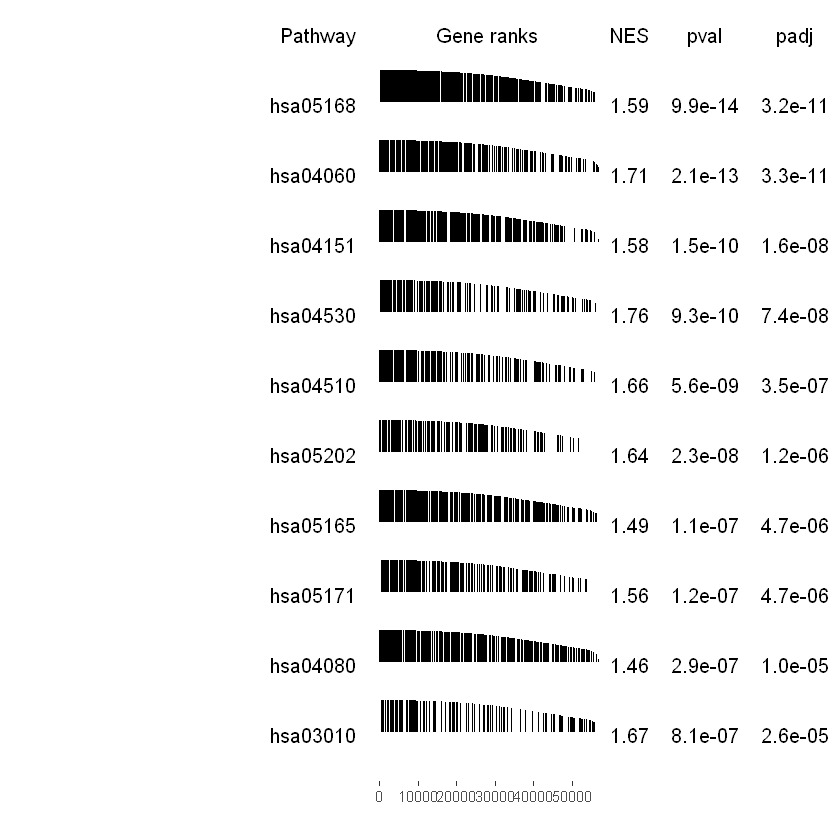

In [54]:
topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n=10), pathway]
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n=10), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(KEGG_hallmark[topPathways], stats, fgseaRes,
              gseaParam=0.5)

## Pathway analysis using GSA package
### Data preparation

In [70]:
# Install GSA from CRAN
suppressMessages({if (!require("GSA"))
        suppressWarnings(install.packages("GSA"))
})

In [102]:
# Loading expression data with groups
data <- readRDS("./data/GSE48350.rds")
expression_data <- data$expression_data
norm_expression_data <- data$norm_expression_data
groups <- data$groups

In [103]:
expression_data$PROBEID <- rownames(expression_data)

In [104]:
probeIDs <- rownames(expression_data)

In [105]:
suppressMessages({
  annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID', 'GENENAME', 'SYMBOL'))
})

In [108]:
# Merge DE result  data frame with annotation table
new_expression_data = merge(annotLookup, expression_data, by="PROBEID")

In [109]:
# Remove NA value
new_expression_data <- new_expression_data[!is.na(new_expression_data$SYMBOL),]
# Remove duplicated genes symbol
new_expression_data <-  new_expression_data[!duplicated(new_expression_data$SYMBOL,fromLast=FALSE),]
rownames(new_expression_data) <- new_expression_data$SYMBOL

In [112]:
# Drop PROBEID, GENENAME, and SYMBOL columns
new_expression_data <- new_expression_data[,-c(1:3)]

In [115]:
genenames= rownames(new_expression_data)

### Enrichment analysis using GSA and GO terms

In [116]:
genesets = GO_term_hallmark
GSA.obj<-GSA(as.matrix(new_expression_data),as.numeric(groups$groups), genenames=genenames, genesets=genesets, resp.type="Two class unpaired", nperms=100)

In [ ]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj, geneset.names=names(genesets),FDRcut=.5)

A table of the negative gene sets. “Negative” means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. Eg for two classes coded 1,2, lower expression correlates with class 2. For survival data, lower expression correlates with higher risk, i.e shorter survival (Be careful, this can be confusing!

In [ ]:
neg.table <-res$negative
neg.table

A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

In [ ]:
pos.table <-res$positive
pos.table

In [ ]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(10, genesets, GSA.obj, genenames)

In [ ]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
GSA.plot(GSA.obj, fac=1, FDRcut = 0.5)

### Enrichment analysis using GSA and KEGG pathways

In [130]:
genesets = KEGG_hallmark
GSA.obj<-GSA(as.matrix(new_expression_data),as.numeric(groups$groups), genenames=genenames, genesets=genesets, resp.type="Two class unpaired", nperms=100)

perm= 10 / 100 
perm= 20 / 100 
perm= 30 / 100 
perm= 40 / 100 
perm= 50 / 100 
perm= 60 / 100 
perm= 70 / 100 
perm= 80 / 100 
perm= 90 / 100 
perm= 100 / 100 


In [132]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj, geneset.names=names(genesets),FDRcut=.5)

A table of the negative gene sets. "Negative" means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. Eg for two classes coded 1,2, lower expression correlates with class 2. For survival data, lower expression correlates with higher risk, i.e shorter survival (Be careful, this can be confusing!)


In [133]:
neg.table <-res$negative
neg.table

Gene_set,Gene_set_name,Score,p-value,FDR
15,hsa00190,-1.0545,0,0
81,hsa00970,-0.8368,0,0
163,hsa04260,-0.6791,0,0
246,hsa04932,-0.6198,0,0
271,hsa05016,-0.7231,0,0
273,hsa05020,-0.6949,0,0
274,hsa05022,-0.5237,0,0
208,hsa04714,-0.5285,0.01,0.2658
268,hsa05010,-0.5025,0.01,0.2658
269,hsa05012,-0.7434,0.01,0.2658


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

In [134]:
pos.table <-res$positive
pos.table

Gene_set,Gene_set_name,Score,p-value,FDR
179,hsa04520,0.4948,0,0
200,hsa04662,0.3778,0,0
223,hsa04810,0.1843,0,0
185,hsa04612,0.5797,0.01,0.3544
194,hsa04640,0.5286,0.01,0.3544
197,hsa04658,0.4347,0.01,0.3544
198,hsa04659,0.3344,0.01,0.3544
343,hsa05332,0.891,0.01,0.3544
349,hsa05416,0.8136,0.01,0.3544
7,hsa00053,0.7591,0.02,0.4908


In [137]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(10, genesets, GSA.obj, genenames)


Gene,Score
ALDH9A1,2.707
HADHA,1.725
ACADVL,1.609
ADH1B,1.513
HADHB,1.175
ACAA1,0.79
ALDH2,0.768
ACSBG1,0.73
ALDH3A2,0.726
ACSL1,0.662


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"2 x values <= 0 omitted from logarithmic plot"


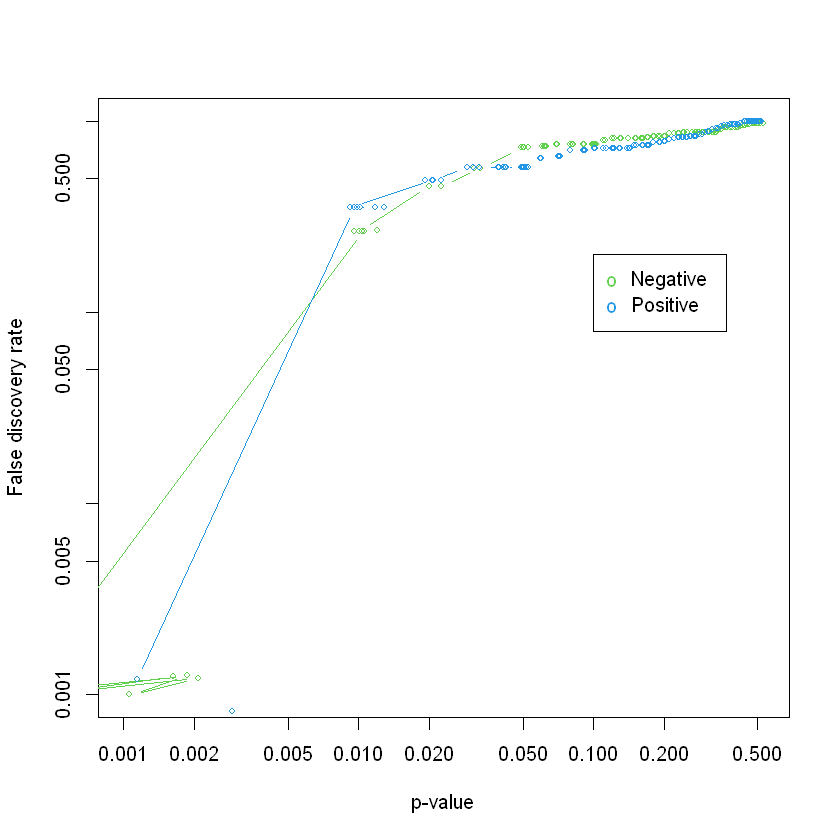

In [138]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
GSA.plot(GSA.obj, fac=1, FDRcut = 0.5)
